# WIP, not updated yet!

In [29]:
from matplotlib import pyplot as plt
import multigrate as mtg
import scanpy as sc

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load preprocessed data

We recommend using raw counts for scRNA-seq and TF-IDF normalized expression for ATAC-seq. You can also input binarized counts for ATAC, but normalized expression seems to integrate a bit better.

In [31]:
rna = sc.read('../../../data/stephenson-2021/stephenson2021_rna_hvg_test.h5ad')
adt = sc.read('../../../data/stephenson-2021/stephenson2021_adt_test.h5ad')

In [32]:
rna

AnnData object with n_obs × n_vars = 10000 × 4000
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'Age', 'split', 'batch'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'count'

In [33]:
adt

AnnData object with n_obs × n_vars = 10000 × 192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'Age', 'split', 'batch'
    var: 'feature_types'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'count'

# Prep the input AnnData object

First, we need to organize anndatas correspoding to different datasets and modalities into 1 anndata object. Here in this example we have 1 CITE-seq dataset, hence we input 2 anndata objects, 1 for RNA modality, 1 for ADT modality, and specify that they are paired (```groups``` argument).

Notes:
- paired datasets have to have the same .obs_names, i.e. index
- if there are batch effects in one dataset, please split the data into batches beforehand, becaues the model treats each input anndata object as 1 batch

If we had more unpaired data here, e.g. 1 paired RNA-ATAC dataset (```rna1```, ```atac1```) and 2 other RNA datasets (```rna2```, ```rna3```), we would have to first subset the RNA modality to the set of common genes (and then possibly to highly variable genes). Then we would need to specify
```adata = [[rna1, rna2, rna3], [atac]]``` and ```groups = [[0, 1, 2], [0]]```.

In [44]:
adata = mtg.data.organize_multiome_anndatas(
    adatas = [[rna], [adt]],     # a list of anndata objects per modality, RNA-seq always goes first
    groups = [[0], [0]],         # specify that paired
    layers = [['count'], [None]] # if need to use data from .layers, if None use .X
)
adata

AnnData object with n_obs × n_vars = 10000 × 4192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'Age', 'split', 'batch', 'group', 'size_factors', '_scvi_batch', '_scvi_labels', 'cell_attn', 'predicted_Status_on_day_collection_summary'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'count'

In [46]:
adata[adata.obs['split'] == 'train']

View of AnnData object with n_obs × n_vars = 10000 × 4192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'Age', 'split', 'batch', 'group', 'size_factors', '_scvi_batch', '_scvi_labels', 'cell_attn', 'predicted_Status_on_day_collection_summary'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'count'

Sanity check: in case of multiple datasets `len(adata)` should be equal `len(rna1) + len(rna2) + len(rna3)`.

From now on, we work with one concatenated anndata object ```adata```.

If using raw counts for scRNA, we need to use NB loss (or ZINB), thus need to calculate `size factors` first. If using normalized counts and MSE for scRNA, `rna_indices_end` does not need to be specified.

In [35]:
mtg.model.MultiVAE.setup_anndata(
    adata,
    rna_indices_end=4000,  # how many features in rna modality
    categorical_covariate_keys=['Sex', 'patient_id', 'Status_on_day_collection_summary'],
    continuous_covariate_keys=['Age'],
)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 10000 cells, 4192 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 3 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/home/icb/anastasia.litinetskaya/miniconda3/envs/multi/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


# Initialize the model

Define the model here. If using raw counts for RNA-seq, use NB loss (`'nb'`), if normalized counts, use MSE (`'mse'`) for RNA, ADT and ATAC. If using binarized counts for ATAC-seq, use BCE (`'bce'`).

In [36]:
model = mtg.model.MultiVAE_MIL(
    adata, 
    modality_lengths=[4000, 192], # how many features per modality
    losses=['nb', 'mse'],         # what losses to use for each modality
    loss_coefs={'kl': 1e-5,
               'integ': 0}, # depending on the datasets, might need to fine-tune loss coeficients, done here
    classification=['Status_on_day_collection_summary'],
    patient_label='patient_id',
)

# Train the model

Can specify the number of epochs by setting `max_epochs` parameter, default is 500.

In [37]:
model.train(max_epochs=2)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
/home/icb/anastasia.litinetskaya/miniconda3/envs/multi/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Epoch 1/2:  50%|█████     | 1/2 [00:00<00:00,  1.17it/s, loss=2.43e+03, v_num=1]

Metric elbo_validation improved. New best score: 2311.026


Epoch 2/2: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s, loss=2.08e+03, v_num=1]

Metric elbo_validation improved by 283.706 >= min_delta = 0.0. New best score: 2027.321


Epoch 2/2: 100%|██████████| 2/2 [00:01<00:00,  1.15it/s, loss=2.08e+03, v_num=1]


In [43]:
adata.obsm['cov_attn']

array([[0.31656384, 0.3776367 , 0.30579948],
       [0.31656384, 0.3776367 , 0.30579948],
       [0.31656384, 0.3776367 , 0.30579948],
       ...,
       [0.31573597, 0.37809616, 0.3061679 ],
       [0.31573597, 0.37809616, 0.3061679 ],
       [0.31573597, 0.37809616, 0.3061679 ]], dtype=float32)

In [40]:
model.history.keys()

dict_keys(['train_loss_step', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train', 'integ_train', 'cycle_train', 'classification_train', 'accuracy_train', 'reg_loss_train', 'regression_train', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'integ_validation', 'cycle_validation', 'classification_validation', 'accuracy_validation', 'reg_loss_validation', 'regression_validation'])

# Inference

Get the latent representation.

In [39]:
model.get_model_output(batch_size=512)
adata

/home/icb/anastasia.litinetskaya/miniconda3/envs/multi/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


AnnData object with n_obs × n_vars = 10000 × 4192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'Age', 'split', 'batch', 'group', 'size_factors', '_scvi_batch', '_scvi_labels', 'cell_attn', 'predicted_Status_on_day_collection_summary'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi', 'bag_classification_true_Status_on_day_collection_summary', 'bag_classification_predictions_Status_on_day_collection_summary', 'bag_predicted_Status_on_day_collection_summary'
    obsm: '_scvi_extra_categoricals', '_scvi_extra_continuous', 'latent', 'cov_attn', 'classification_predictions_Status_on_day_collect

Visualize results.

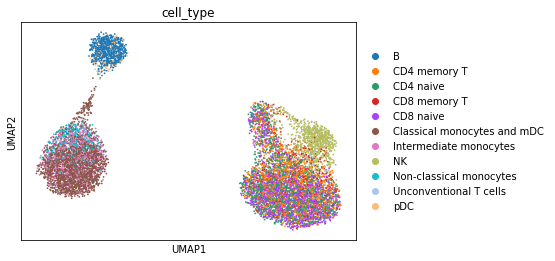

In [15]:
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata)
sc.pl.umap(adata, color='cell_type')

In [ ]:
mil.classification_report(level='bag')

# Query

In [ ]:
mtg.model.MultiVAE_MIL.setup_query(
                adata,     
                query, 
                # class_label='condition',
                rna_indices_end=4000, 
                categorical_covariate_keys=['sex', 'patient'],
                continuous_covariate_keys=['age'],
                )
query

In [ ]:
new_mil = mtg.model.MultiVAE_MIL.load_query_data(query, mil)

In [ ]:
new_mil.finetune_query(max_epochs=1, batch_size=512, plot_losses=True)

In [ ]:
new_mil.get_model_output(batch_size=512)
query